# Malha

In [19]:
import xmltodict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from datetime import datetime

pd.options.display.max_rows = 99

arquivo_add = str(datetime.now())[-6:]


In [20]:
with open('malha.net.xml', 'rb') as f:
    malha_xml = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)


In [21]:
malha_viaria = []

for attr in malha_xml['net']['edge']:
    malha_viaria.append([attr['id'], attr['name'], attr['priority'],
                         attr['param'][0]['value'], attr['param'][1]['value']])

malha = pd.DataFrame(malha_viaria, columns=[
                     'id', 'name', 'priority', 'vmax', 'vmin'])

malha.sort_values('priority', inplace=True, ascending=False)
malha[['priority', 'vmax', 'vmin']] = malha[['priority', 'vmax', 'vmin']].apply(pd.to_numeric)

malha.head()


,id,name,priority,vmax,vmin
11,gneE2,Av.Ver.Abrahão João Francisco,5,5.94,4.67
24,gneE8,Av.Ver.Abrahão João Francisco,5,5.94,4.67
23,gneE7,Av.Ver.Abrahão João Francisco,5,5.94,4.67
6,gneE14,Av.Ver.Abrahão João Francisco,5,5.94,4.67
7,gneE15,Av.Ver.Abrahão João Francisco,5,5.94,4.67


# Rotas e demandas

In [22]:
with open('demanda.rou.xml', 'rb') as f:
    dem_xml = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)

# print(json.dumps(dem_xml['routes']['route'], indent=4, ensure_ascii=False))

In [23]:
rotas = pd.DataFrame(dem_xml['routes']['route'])

rotas.drop(columns=['color'], inplace=True)

rotas.head()

,edges,id
0,gneE0 gneE1 gneE2 gneE3 gneE4,route_0
1,gneE0 gneE1 gneE2 gneE3 gneE15 gneE16 gneE17,route_1
2,gneE10 gneE11 gneE12 gneE14 gneE2 gneE24,route_10
3,gneE26 gneE23 gneE15 gneE7 gneE8 gneE9,route_11
4,gneE26 gneE23 gneE15 gneE16 gneE17,route_12


In [24]:
demandas = pd.DataFrame(dem_xml['routes']['flow'])

demandas.head()

,id,type,begin,departSpeed,route,end,number
0,flow_0,veic_pass,0.00,8.00,route_0,3600.00,10
1,flow_1,veic_pass,0.00,8.00,route_1,3600.00,10
2,flow_10,veic_pass,0.00,6.00,route_18,3600.00,10
3,flow_11,veic_pass,0.00,6.00,route_19,3600.00,10
4,flow_12,veic_pass,0.00,8.00,route_2,3600.00,10


# Resultados da simulação

In [25]:
result_sumo = pd.read_csv('full.output.csv', sep=';')
result_sumo.head()

,data_timestep,vehicle_CO,vehicle_CO2,vehicle_HC,vehicle_NOx,vehicle_PMx,vehicle_angle,vehicle_eclass,vehicle_electricity,vehicle_fuel,...,lane_NOx,lane_PMx,lane_electricity,lane_fuel,lane_id,lane_maxspeed,lane_meanspeed,lane_noise,lane_occupancy,lane_vehicle_count
0,0.0,39.08,2089.12,0.22,0.74,0.02,52.95,HBEFA3/PC_G_EU4,0.0,0.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,63.55,2128.82,0.34,0.81,0.03,95.85,HBEFA3/PC_G_EU4,0.0,0.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,39.08,2089.12,0.22,0.74,0.02,233.80,HBEFA3/PC_G_EU4,0.0,0.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,63.55,2128.82,0.34,0.81,0.03,95.76,HBEFA3/PC_G_EU4,0.0,0.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,63.55,2128.82,0.34,0.81,0.03,351.60,HBEFA3/PC_G_EU4,0.0,0.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
result_sumo.columns

Index(['data_timestep', 'vehicle_CO', 'vehicle_CO2', 'vehicle_HC',
       'vehicle_NOx', 'vehicle_PMx', 'vehicle_angle', 'vehicle_eclass',
       'vehicle_electricity', 'vehicle_fuel', 'vehicle_id', 'vehicle_lane',
       'vehicle_noise', 'vehicle_pos', 'vehicle_route', 'vehicle_speed',
       'vehicle_type', 'vehicle_waiting', 'vehicle_x', 'vehicle_y', 'edge_id',
       'edge_traveltime', 'lane_CO', 'lane_CO2', 'lane_HC', 'lane_NOx',
       'lane_PMx', 'lane_electricity', 'lane_fuel', 'lane_id', 'lane_maxspeed',
       'lane_meanspeed', 'lane_noise', 'lane_occupancy', 'lane_vehicle_count'],
      dtype='object')

In [27]:
result_sumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157934 entries, 0 to 157933
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   data_timestep        157934 non-null  float64
 1   vehicle_CO           18010 non-null   float64
 2   vehicle_CO2          18010 non-null   float64
 3   vehicle_HC           18010 non-null   float64
 4   vehicle_NOx          18010 non-null   float64
 5   vehicle_PMx          18010 non-null   float64
 6   vehicle_angle        18010 non-null   float64
 7   vehicle_eclass       18010 non-null   object 
 8   vehicle_electricity  18010 non-null   float64
 9   vehicle_fuel         18010 non-null   float64
 10  vehicle_id           18010 non-null   object 
 11  vehicle_lane         18010 non-null   object 
 12  vehicle_noise        18010 non-null   float64
 13  vehicle_pos          18010 non-null   float64
 14  vehicle_route        18010 non-null   object 
 15  vehicle_speed    

In [28]:
result_sumo['vehicle_edge'] = result_sumo['vehicle_lane'].str.split(
    '_').str[0]

veics_sumo = result_sumo[result_sumo['vehicle_route'].notnull(
)][['data_timestep', 'vehicle_route', 'vehicle_edge', 'vehicle_speed']]

veics_sumo.head()

veic_sumo = veics_sumo.groupby(['vehicle_route', 'vehicle_edge'], as_index=False)['vehicle_speed'].median()


# Detectores

In [29]:
tree_add = ET.parse('adicionais.xml')
root_add = tree_add.getroot()

b2tf_add = root_add.findall('./e1Detector')

addicional_atual = b2tf_add[0].attrib['file']

with open(addicional_atual, 'rb') as f:
    detect = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)

In [30]:
detec_list = []

for attr in detect['detector']['interval']:
    detec_list.append(
        [attr['id'], float(attr['speed']), int(attr['nVehEntered'])])

detectores = pd.DataFrame(detec_list, columns=[
    'name', 'speed', 'nVehEntered'])

detectores['id'] = detectores['name'].str.split('_').str[1]


In [31]:
detectores_gb = detectores.groupby(['id']).agg({'speed':'median', 'nVehEntered':'sum'}).reset_index()

In [32]:
detectores_malha = pd.merge(detectores_gb, malha, how='left', on=['id']).reset_index()

In [33]:
#detectores_malha.at[1,'speed'] = 4

In [34]:
def comparar_vels(x):
    if x['speed'] > x['vmax']:
        return x['speed'] - x['vmax']
    elif x['speed'] < x['vmin']:
        return x['speed'] - x['vmin']
    else:
        return 0

detectores_malha['dif'] = detectores_malha.apply(comparar_vels, axis=1)


In [35]:
detectores_malha.head()

,index,id,speed,nVehEntered,name,priority,vmax,vmin,dif
0,0,gneE1,7.755,40,Av.Ver.Abrahão João Francisco,4,4.66,2.55,3.095
1,1,gneE12,8.895,30,R.Pres.João Goulart,1,6.04,3.30,2.855
2,2,gneE19,9.955,40,R.Estud.Renato Victorino,1,6.04,3.30,3.915
3,3,gneE23,10.280,30,R.José Siqueira,3,6.04,3.30,4.240
4,4,gneE6,7.940,41,Av.Ver.Abrahão João Francisco,4,4.66,2.55,3.280


# resultados por rota

In [36]:
rotas_det = {}
detect_edges = set(detectores_malha['id'])

for idx, row in rotas.iterrows():
    rotas_det[row['id']] = {
        'priority': malha.loc[malha['id'] == row['edges'].split()[0]]['priority'].values[0],
        'edge': [],
        'vmax': [],
        'vmin': [],
        'sumo': [],
        'sumo_sensor_speed': None,
        'vmax_sensor': None,
        'vmin_sensor': None,
        'sendor_edge': None,
        'sensor_speed': None,
        'sensor_veic':  None
    }

    for edge in row['edges'].split():
        rotas_det[row['id']]['edge'].append(edge)
        vmax = malha[malha['id'] == edge]['vmax'].values[0]
        rotas_det[row['id']]['vmax'].append(vmax)
        vmin = malha[malha['id'] == edge]['vmin'].values[0]
        rotas_det[row['id']]['vmin'].append(vmin)
        speed_sumo = veic_sumo[veic_sumo['vehicle_edge']
                               == edge]['vehicle_speed'].values[0]
        rotas_det[row['id']]['sumo'].append(speed_sumo)

        if edge in detect_edges:
            detector_edge = detectores_malha[detectores_malha['id']
                                             == edge]['id'].values[0]
            rotas_det[row['id']]['sensor_speed'] = detectores_malha[detectores_malha['id']
                                                                    == edge]['speed'].values[0]
            rotas_det[row['id']]['sensor_veic'] = detectores_malha[detectores_malha['id']
                                                                   == edge]['nVehEntered'].values[0]
            rotas_det[row['id']]['sendor_edge'] = detector_edge

            if edge == detector_edge:
                rotas_det[row['id']]['sumo_sensor_speed'] = speed_sumo
                rotas_det[row['id']]['vmax_sensor'] = vmax
                rotas_det[row['id']]['vmin_sensor'] = vmin


In [37]:
rotas_det.keys()

dict_keys(['route_0', 'route_1', 'route_10', 'route_11', 'route_12', 'route_13', 'route_14', 'route_15', 'route_16', 'route_17', 'route_18', 'route_19', 'route_2', 'route_20', 'route_3', 'route_4', 'route_5', 'route_6', 'route_7', 'route_8', 'route_9'])

In [38]:
rotas_det['route_12']

{'priority': 3,
 'edge': ['gneE26', 'gneE23', 'gneE15', 'gneE16', 'gneE17'],
 'vmax': [11.0, 6.04, 5.94, 11.0, 11.0],
 'vmin': [7.7, 3.3, 4.67, 7.7, 7.7],
 'sumo': [10.81, 10.84, 7.5649999999999995, 9.035, 9.97],
 'sumo_sensor_speed': 10.84,
 'vmax_sensor': 6.04,
 'vmin_sensor': 3.3,
 'sendor_edge': 'gneE23',
 'sensor_speed': 10.28,
 'sensor_veic': 30}

## Gráfico com a progressão da rota na simulação / velocidade máxima e mínima esperada.

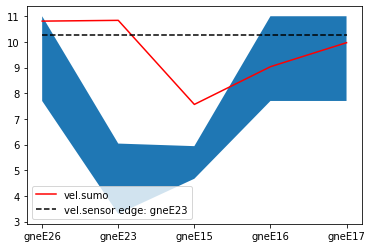

In [39]:
rota_plot = pd.DataFrame.from_dict(rotas_det['route_12'])
rota_plot_label = f"vel.sensor edge: {rota_plot['sendor_edge'].values[0]}"
col = rota_plot.loc[:, 'vmax':'vmin']
plt.plot('edge', 'sumo', label='vel.sumo', c='red', data=rota_plot)
plt.plot('edge', 'sensor_speed', label=rota_plot_label, c='black', linestyle="--", data=rota_plot)
plt.fill_between(x='edge', y1='vmin', y2='vmax', data=rota_plot)
plt.legend()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

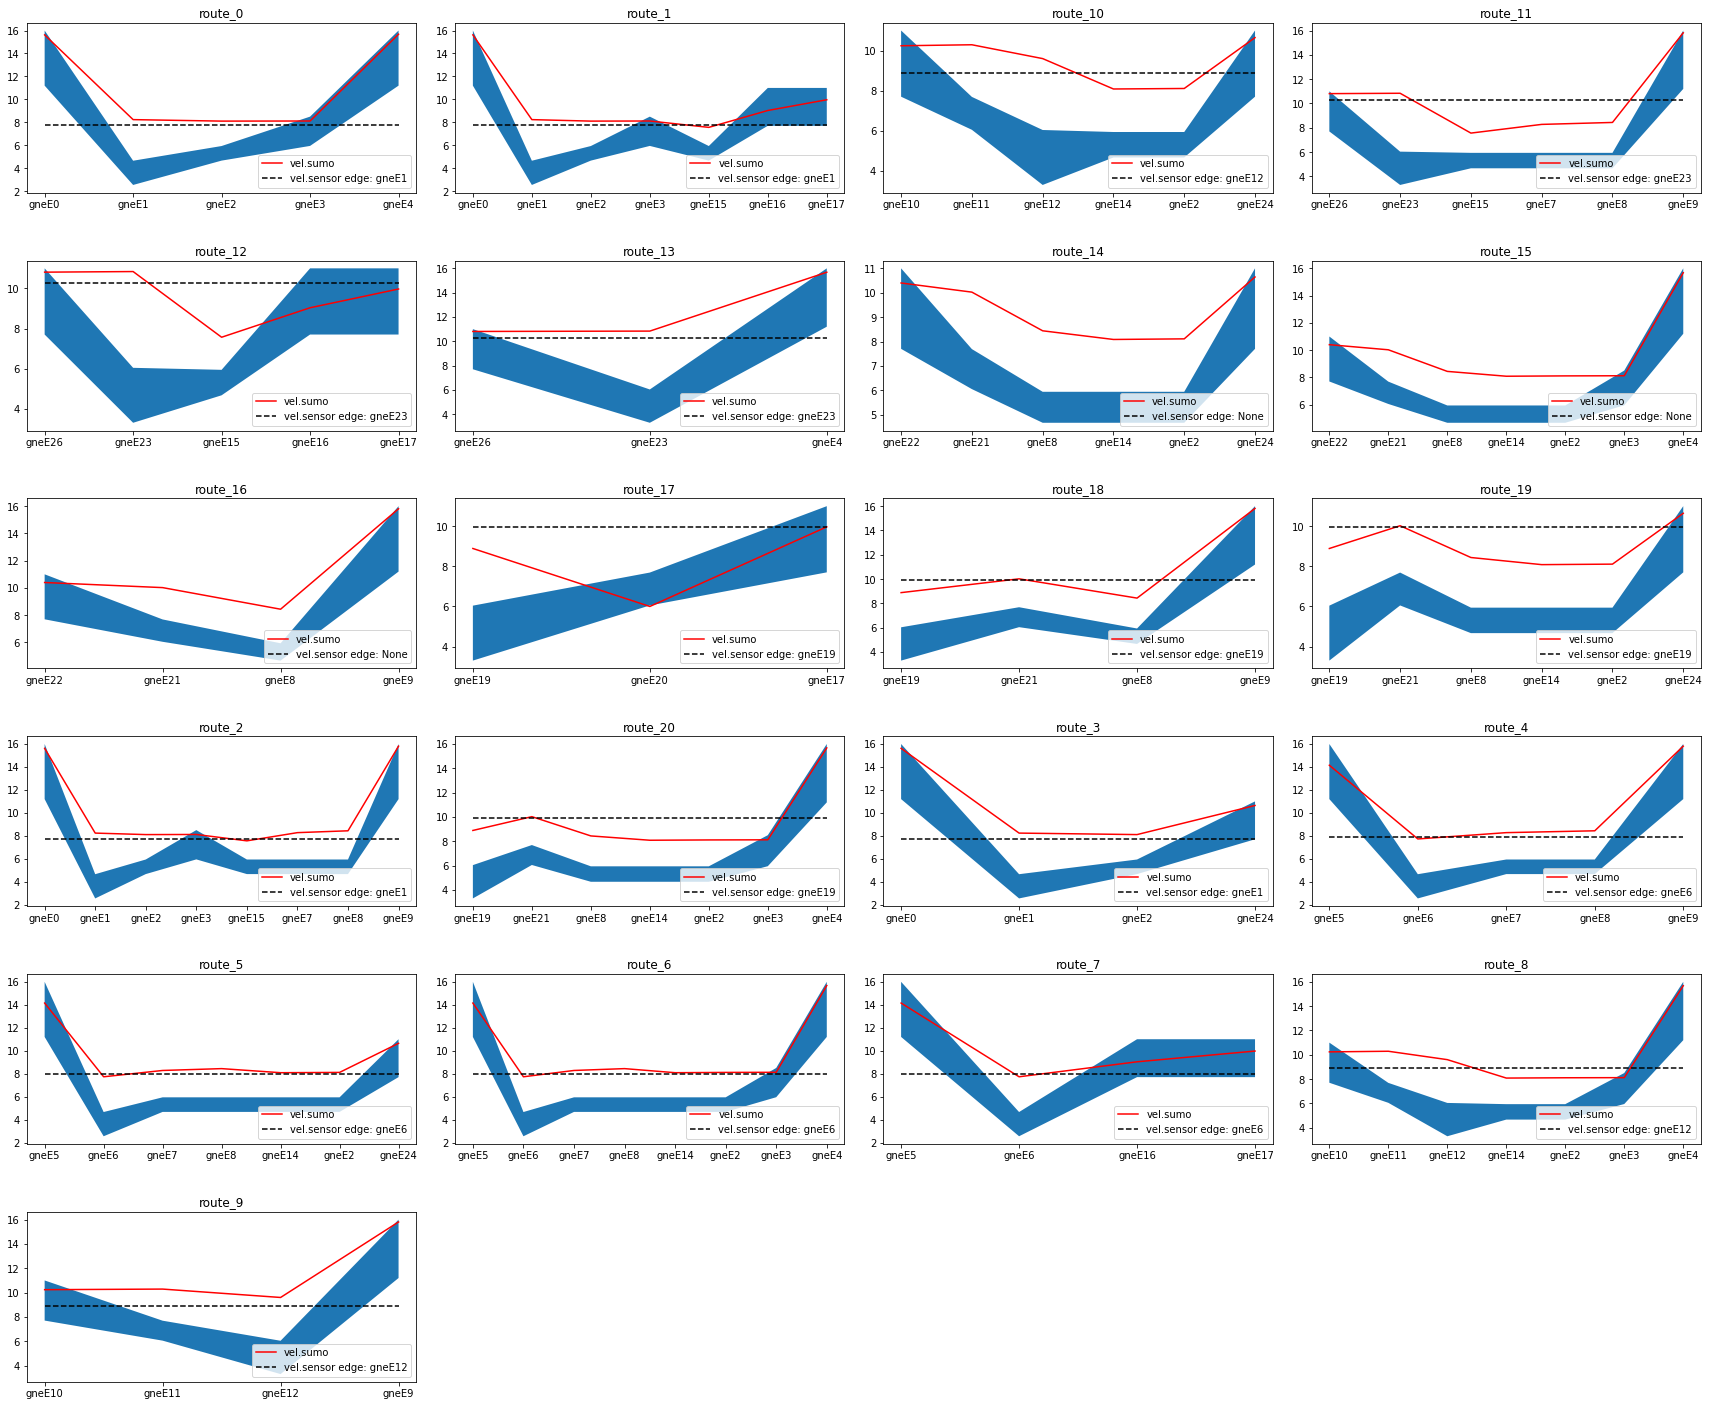

In [40]:
fig = plt.figure(figsize=(30, 25))
fig.subplots_adjust(hspace=.4, wspace=.1)

for idx, rota in enumerate(rotas_det.keys()):
    rota_plot = pd.DataFrame.from_dict(rotas_det[rota])
    rota_plot_label = f"vel.sensor edge: {rota_plot['sendor_edge'].values[0]}"
    fig.add_subplot(6, 4, idx+1)
    plt.plot('edge', 'sumo', label='vel.sumo', c='red', data=rota_plot)
    plt.plot('edge', 'sensor_speed', label=rota_plot_label,
             c='black', linestyle="--", data=rota_plot)
    #rota_plot.plot(x='edge', y='sumo', c='red', ax=ax)
    plt.fill_between(x='edge', y1='vmin', y2='vmax', data=rota_plot)
    plt.legend(loc=4)
    plt.title(rota)

plt.savefig(f'resultados/plots/{arquivo_add}.png')
plt.show


## novos valores rota, prioridade 4 (máxima encontrada no início de uma rota)

Alterações no número de veículos próxima simulação

In [ ]:
malha['priority'].unique()

## Salvando novo xml (teste 1)

dem_xml

In [ ]:
for ln in b2tf_add:
    ln.attrib['file'] = f'resultados/detectores/{arquivo_add}.xml'

tree_add.write("adicionais.xml")

In [ ]:
tree = ET.parse('demanda.rou.xml')
root = tree.getroot()

In [ ]:
# localizar uma rota

#b2tf = root.find("./flow[@id='flow_6']")
#print(b2tf.attrib)
#b2tf.attrib['number'] = '100'
#print(b2tf.attrib)

In [ ]:
for rota in rotas_det:
    b2tf = root.find(f'./flow[@route="{rota}"]')
    if rotas_det[rota]['demand_num'] > 0:
        b2tf.attrib['number'] = str(int(rotas_det[rota]['demand_num']))
    else:
        b2tf.attrib['number'] = '10'
    print(b2tf.attrib)

In [ ]:
tree.write("demanda.rou.xml")
tree.write(f'resultados/demandas/{arquivo_add}.rou.xml')

## rodar próx.passo

In [ ]:
# rodar simulação
!sumo simulacao.sumocfg


In [ ]:
# to csv
!python3 xml2csv.py full.output.xml
